In [51]:
import os, sys
import random
import numpy as np
import errno
import csv
# from PIL import Image
import io
from io import BytesIO
from PIL import Image, ImageFile
import urllib.request

In [81]:
foreground_path= "/Users/kamilademkova/Documents/DSR/Project/images/foregrounds"
background_path= "/Users/kamilademkova/Documents/DSR/Project/images/backgrounds"

#size = 128, 128

def compose_images(foreground_path, background_path):
    # Make sure the foreground path is valid and open the image
    assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
#     print ("here we go")
#     print (foreground_path)
#     print (os.path.splitext(foreground_path))
#     print ((foreground_path)[1])
#     print ((foreground_path)[1].lower())
    assert os.path.splitext(foreground_path)[1].lower() == '.png', 'foreground must be a .png file'
    
#    can't use because converts to JPEG and need PNG. even if change outfile as PNG
# for foreground in sys.argv[1:]:
#         outfile = os.path.splitext(foreground)[0] + ".thumbnail"
#         if foreground != outfile:
#             try:
#                 im = Image.open(foreground)
#                 im.thumbnail(size)
#                 im.save(outfile, 'JPEG')
#             except IOError:
#                 print ("cannot create thumbnail for", foreground)
    
    #Make sure foreground has correct amount of bites
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
#   for i in foreground:
#     with open(foreground, 'rb') as f:
#         b = BytesIO()
#         f.seek(15, 0)
#         b.write(f.read())
    
#     im = Image.open(b)
#     im.load()
    
#     with open("/Users/kamilademkova/Documents/DSR/Project/images/foregrounds/IMG_9715.png", "rb") as f:
#         b = io.BytesIO(f.read())
#         im = Image.open(b)
#         im.save('out.png')
  
    foreground = Image.open(foreground_path)
    
    foreground_alpha = np.array(foreground.getchannel(3))
    assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
    assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
    
    print (background_path)
    print (os.path.splitext(background_path)[1])
    
    assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', 'jpeg'], \
        'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    background = Image.open(background_path)
    background = background.convert('RGBA')

    # Rotate the foreground
    angle_degrees = random.randint(0, 359)
    foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
    # Scale the foreground
    scale = random.random() * .3 + .7 # Pick something between 0.7 and 1
    new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
    foreground = foreground.resize(new_size, resample=Image.BICUBIC)
    
    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(max_xy_position[1]//2, max_xy_position[1]))
    
    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
        
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    alpha_mask = foreground.getchannel(3)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]
    y1 = bbox[0]  #min
    x1 = bbox[1]  #min
    y2 = bbox[2]  #max
    x2 = bbox[3]  #max

    
#     center-x = x / W width(in pixels) of the whole image
    cx = ((x2+x1)/2)/composite.size[0]
#     center-y = y / H height(in pixels) of the whole image
    cy = ((y2+y1)/2)/composite.size[1]
#     width = w / W width(in pixels) of the whole image
    width = (x2 - x1)/composite.size[0]
#     height = h / H height(in pixels) of the whole image
    height = (y2 - y1)/composite.size[1]
# x – x-coordinate(in pixels) of the center of the bounding box
# y – y-coordinate(in pixels) of the center of the bounding box
# w – width(in pixels) of the bounding box
# h – height(in pixels) of the bounding box
# W – width(in pixels) of the whole image
# H – height(in pixels) of the whole image

    return composite, hard_mask, bbox, cx, cy, width, height

In [85]:
# Get lists of foreground and background image paths
dataset_dir = '/Users/kamilademkova/Documents/DSR/Project/images'
backgrounds_dir = os.path.join(dataset_dir, 'backgrounds')
foregrounds_dir = os.path.join(dataset_dir, 'foregrounds')
backgrounds = [os.path.join(backgrounds_dir, file_name) for file_name in os.listdir(backgrounds_dir) if not file_name.startswith('.')]
foregrounds = [os.path.join(foregrounds_dir, file_name) for file_name in os.listdir(foregrounds_dir) if not file_name.startswith('.')]

#[f for f in os.listdir(path) if not f.startswith('.')]

# Create an output directory
output_dir = os.path.join(dataset_dir, 'generated')
try:
    os.mkdir(output_dir)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Create a list to keep track of images and mask annotations
csv_lines = []

# Generate 5 new images
for i in range(1500):
    foreground_path = random.choice(foregrounds)
    background_path = random.choice(backgrounds)
    composite, mask, bbox, cx, cy, width, height = compose_images(foreground_path, background_path)
    
    composite_path = os.path.join(output_dir, 'image_{0:04d}.png'.format(i))
    composite.save(composite_path)
    
    mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
    mask.save(mask_path)
    
    bbtx_path = os.path.join(output_dir, 'image_{0:04d}.txt'.format(i))
    
    f = open(bbtx_path, "w+")
    f.write("0" +" "+ str(cx)+" "+ str(cy)+" "+ str(width) +" " +str(height) +"\n")
    f.close()
    
    csv_lines.append([composite_path, bbox, mask_path])
    
# Output the annotations csv
annotations_csv_path = os.path.join(output_dir, 'annotations.csv')
with open(annotations_csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for csv_line in csv_lines:
        writer.writerow(csv_line)

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4607_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4494_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5203_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4254_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4450_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4709_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5643_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4836_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5511_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4715_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5047_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4202_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4992_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5379_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5375_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4134_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4876_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5038_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4734_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4394_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4486_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4947_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5016_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5175_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5417_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5664_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4945_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4657_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4632_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5667_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4616_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4854_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4690_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4636_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4399_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4853_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4529_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5646_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5597_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5246_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5613_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5305_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5650_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4864_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5694_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5544_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4784_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5045_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4564_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5033_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5196_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5599_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4760_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4195_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4314_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5268_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4493_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4859_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4342_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5629_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4486_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4342_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4462_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4689_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5231_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5295_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4839_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4953_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5032_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4764_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4371_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5632_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4927_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4287_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4565_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4277_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5339_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4300_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4273_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5509_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4612_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5366_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4851_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4757_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5353_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4510_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4458_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5326_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5230_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4311_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4668_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5573_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4677_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5405_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4548_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5194_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5403_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5177_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5533_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4364_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5688_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5205_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5199_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4396_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4865_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4883_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5023_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4631_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4406_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4542_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4343_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4835_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4983_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4713_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5098_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5115_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4328_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5360_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4757_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5576_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5640_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4702_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4666_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5402_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5216_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5219_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4957_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4952_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5163_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4201_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5299_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4230_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4153_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4453_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4424_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4994_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5341_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4765_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5450_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4299_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4953_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4941_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5315_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4353_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4152_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5444_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5107_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4242_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4455_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4641_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4740_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4853_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4395_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4340_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4247_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4296_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4928_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5390_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4928_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4158_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5105_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4538_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5359_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4135_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5152_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5662_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4803_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4356_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5040_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4673_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4552_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4723_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5006_cam

/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4875_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4406_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4443_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4252_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4200_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4957_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4303_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5258_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4518_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/5395_cam-image_array_.jpg
.jpg
/Users/kamilademkova/Documents/DSR/Project/images/backgrounds/4315_cam

In [4]:
# check if have extra bites
# with open('/Users/kamilademkova/Documents/DSR/Project/images/foregrounds/glassimg.png', 'rb') as fp:
#     data = fp.read()
#     out = []
#     for char in data[:23]:
#         out.append(str(char))
#     print(' '.join(out))
# output 137 80 78 71 13 10 26 10 0 0 0 13 73 72 68 82 0 0 10 112 0 0 10
# should be 137 80 78 71 13 10 26 10

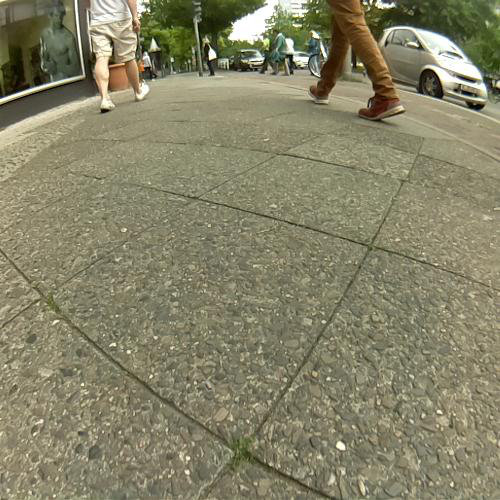

In [7]:
sample_image_path = csv_lines[0][0]
sample_image = Image.open(sample_image_path)
sample_image

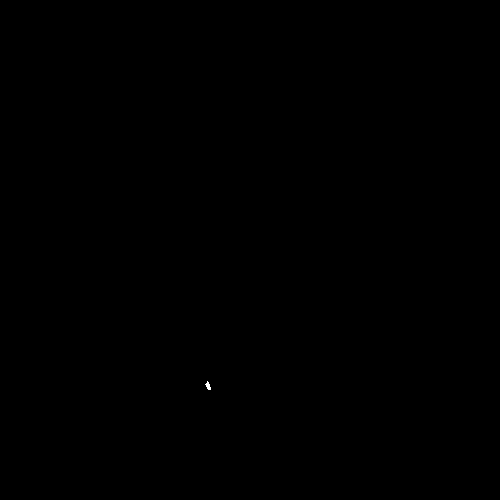

In [8]:
sample_mask_path = csv_lines[0][2]
sample_mask = Image.open(sample_mask_path)
sample_mask